In [1]:
#Subimos tu API key de Kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"wilberbarc","key":"10f88b754f4b38b10b72dabe8c8d8b52"}'}

In [2]:
#instalamos kaggle y autenticamos para poder decargar
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
# Descargamos el dataset de Kaggle
!kaggle datasets download -d mostafaabla/garbage-classification
# Descomprimir el archivo
!unzip garbage-classification.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: garbage_classification/paper/paper381.jpg  
  inflating: garbage_classification/paper/paper382.jpg  
  inflating: garbage_classification/paper/paper383.jpg  
  inflating: garbage_classification/paper/paper384.jpg  
  inflating: garbage_classification/paper/paper385.jpg  
  inflating: garbage_classification/paper/paper386.jpg  
  inflating: garbage_classification/paper/paper387.jpg  
  inflating: garbage_classification/paper/paper388.jpg  
  inflating: garbage_classification/paper/paper389.jpg  
  inflating: garbage_classification/paper/paper39.jpg  
  inflating: garbage_classification/paper/paper390.jpg  
  inflating: garbage_classification/paper/paper391.jpg  
  inflating: garbage_classification/paper/paper392.jpg  
  inflating: garbage_classification/paper/paper393.jpg  
  inflating: garbage_classification/paper/paper394.jpg  
  inflating: garbage_classification/paper/paper395.jpg  
  inflating: garbage_classif

In [1]:
import os

PATH = '/content/garbage_classification'

classes = os.listdir(PATH)
classes

['green-glass',
 'clothes',
 'brown-glass',
 'cardboard',
 'white-glass',
 'paper',
 'biological',
 'shoes',
 'plastic',
 'metal',
 'battery',
 'trash']

In [2]:
imgs, labels = [], []

for i, lab in enumerate(classes):
  paths = os.listdir(f'{PATH}/{lab}')
  print(f'Categoría: {lab}. Imágenes: {len(paths)}')
  paths = [p for p in paths if p[-3:] == "jpg"]
  imgs += [f'{PATH}/{lab}/{img}' for img in paths]
  labels += [i]*len(paths)

Categoría: green-glass. Imágenes: 629
Categoría: clothes. Imágenes: 5325
Categoría: brown-glass. Imágenes: 607
Categoría: cardboard. Imágenes: 891
Categoría: white-glass. Imágenes: 775
Categoría: paper. Imágenes: 1050
Categoría: biological. Imágenes: 985
Categoría: shoes. Imágenes: 1977
Categoría: plastic. Imágenes: 865
Categoría: metal. Imágenes: 769
Categoría: battery. Imágenes: 945
Categoría: trash. Imágenes: 697


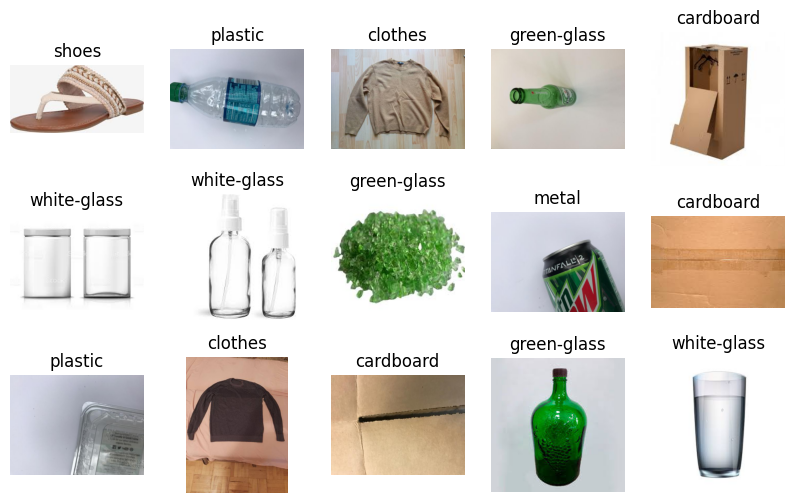

In [3]:
import random
from skimage import io
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(imgs)-1)
    img = io.imread(imgs[ix])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(classes[labels[ix]])
plt.show()

In [4]:
from sklearn.model_selection import train_test_split

train_imgs, test_imgs, train_labels, test_labels = train_test_split(imgs, labels, test_size=0.2, stratify=labels)

len(train_imgs), len(test_imgs)

(12412, 3103)

In [5]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, trans, device):
    self.X = X
    self.y = y
    self.trans = trans
    self.device = device

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    # cargar la imágen
    img = io.imread(self.X[ix])
    # aplicar transformaciones
    if self.trans:
      img = self.trans(image=img)["image"]
    return torch.from_numpy(img / 255.).float().permute(2,0,1), torch.tensor(self.y[ix])

In [6]:
import albumentations as A

trans = A.Compose([
    A.Resize(224, 224)
])

dataset = {
    'train': Dataset(train_imgs, train_labels, trans, device),
    'test': Dataset(test_imgs, test_labels, trans, device)
}

len(dataset['train']), len(dataset['test'])

(12412, 3103)

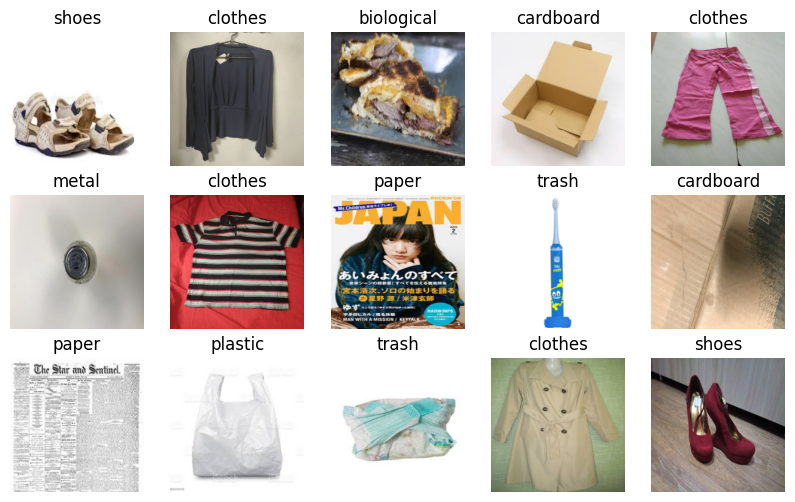

In [7]:
fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(dataset['train'])-1)
    img, lab = dataset['train'][ix]
    ax.imshow(img.permute(1,2,0))
    ax.axis('off')
    ax.set_title(classes[lab])
plt.show()

In [8]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=256, shuffle=False)
}

imgs, labels = next(iter(dataloader['train']))
imgs.shape

torch.Size([64, 3, 224, 224])

In [9]:
!pip install transformers


In [10]:
!pip install timm

In [12]:
# from transformers import AutoModel, AutoConfig

# # URL directa del modelo en Hugging Face Hub
# model_url = "https://huggingface.co/timm/efficientnet_b2_ra_in1k/resolve/main"

# # Configuración del modelo
# config = AutoConfig.from_pretrained(model_url)

# # Cargar el modelo preentrenado
# efficientnet = AutoModel.from_pretrained(model_url, config=config)

# # Muestra la arquitectura del modelo
# print(efficientnet)


In [13]:
import timm

# Crear el modelo efficientnet_b2 preentrenado
model_name = 'efficientnet_b2'
efficientnet = timm.create_model(model_name)

# Muestra la arquitectura del modelo
efficientnet

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
      

In [14]:
class Model(torch.nn.Module):
  def __init__(self, n_outputs=12, pretrained=False, freeze=False):
    super().__init__()
    # descargamos resnet
    efficientnet = timm.create_model('efficientnet_b2',pretrained=pretrained)
    # nos quedamos con todas las capas menos la última
    self.efficientnet = torch.nn.Sequential(*list(efficientnet.children())[:-1])
    if freeze:
      for param in self.efficientnet.parameters():
        param.requires_grad=False
    # añadimos una nueva capa lineal para llevar a cabo la clasificación
    self.fc = torch.nn.Linear(1408, 12)

  def forward(self, x):
    x = self.efficientnet(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

  def unfreeze(self):
    for param in self.efficientnet.parameters():
        param.requires_grad=True

In [15]:
model = Model()
outputs = model(torch.randn(64, 3, 224, 224))
outputs.shape

torch.Size([64, 12])

In [16]:
from tqdm import tqdm
import numpy as np

def fit(model, dataloader, epochs=5, lr=1e-2):
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

In [17]:
model = Model()
fit(model, dataloader, epochs=15)

val_loss 2.14298 val_acc 0.34588: 100%|██████████| 13/13 [00:21<00:00,  1.67s/it]


Epoch 1/15 loss 2.22251 val_loss 2.14298 acc 0.33403 val_acc 0.34588


val_loss 1.88311 val_acc 0.39704: 100%|██████████| 13/13 [00:16<00:00,  1.27s/it]


Epoch 2/15 loss 2.02327 val_loss 1.88311 acc 0.36749 val_acc 0.39704


val_loss 1.75418 val_acc 0.44715: 100%|██████████| 13/13 [00:16<00:00,  1.25s/it]


Epoch 3/15 loss 1.78008 val_loss 1.75418 acc 0.43395 val_acc 0.44715


val_loss 1.71235 val_acc 0.46074: 100%|██████████| 13/13 [00:16<00:00,  1.26s/it]


Epoch 4/15 loss 1.64887 val_loss 1.71235 acc 0.45997 val_acc 0.46074


val_loss 1.60376 val_acc 0.48140: 100%|██████████| 13/13 [00:17<00:00,  1.34s/it]


Epoch 5/15 loss 1.54578 val_loss 1.60376 acc 0.48214 val_acc 0.48140


val_loss 1.41946 val_acc 0.53235: 100%|██████████| 13/13 [00:16<00:00,  1.29s/it]


Epoch 6/15 loss 1.43115 val_loss 1.41946 acc 0.51820 val_acc 0.53235


val_loss 1.33940 val_acc 0.54181: 100%|██████████| 13/13 [00:16<00:00,  1.29s/it]


Epoch 7/15 loss 1.33745 val_loss 1.33940 acc 0.54912 val_acc 0.54181


val_loss 1.33861 val_acc 0.55781: 100%|██████████| 13/13 [00:17<00:00,  1.32s/it]


Epoch 8/15 loss 1.23628 val_loss 1.33861 acc 0.58301 val_acc 0.55781


val_loss 1.17555 val_acc 0.61273: 100%|██████████| 13/13 [00:16<00:00,  1.30s/it]


Epoch 9/15 loss 1.14077 val_loss 1.17555 acc 0.61659 val_acc 0.61273


val_loss 1.15336 val_acc 0.61129: 100%|██████████| 13/13 [00:16<00:00,  1.30s/it]


Epoch 10/15 loss 1.05676 val_loss 1.15336 acc 0.64235 val_acc 0.61129


val_loss 1.07192 val_acc 0.63744: 100%|██████████| 13/13 [00:17<00:00,  1.32s/it]


Epoch 11/15 loss 0.97050 val_loss 1.07192 acc 0.67185 val_acc 0.63744


val_loss 1.08875 val_acc 0.63796: 100%|██████████| 13/13 [00:16<00:00,  1.27s/it]


Epoch 12/15 loss 0.90068 val_loss 1.08875 acc 0.69544 val_acc 0.63796


val_loss 1.05760 val_acc 0.64615: 100%|██████████| 13/13 [00:17<00:00,  1.33s/it]


Epoch 13/15 loss 0.82805 val_loss 1.05760 acc 0.72324 val_acc 0.64615


val_loss 1.19101 val_acc 0.62700: 100%|██████████| 13/13 [00:17<00:00,  1.35s/it]


Epoch 14/15 loss 0.75515 val_loss 1.19101 acc 0.74774 val_acc 0.62700


val_loss 1.05828 val_acc 0.67132: 100%|██████████| 13/13 [00:17<00:00,  1.33s/it]

Epoch 15/15 loss 0.69844 val_loss 1.05828 acc 0.76752 val_acc 0.67132


Transfer Learning
Ahora vamos a entrenar el mismo caso pero, en este caso, utilizando los pesos pre-entrenados de efficientnet_b2.

In [18]:
model = Model(pretrained=True, freeze=True)
fit(model, dataloader)

val_loss 1.06118 val_acc 0.82166: 100%|██████████| 13/13 [00:16<00:00,  1.30s/it]


Epoch 1/5 loss 1.47087 val_loss 1.06118 acc 0.62292 val_acc 0.82166


val_loss 0.74311 val_acc 0.87484: 100%|██████████| 13/13 [00:17<00:00,  1.32s/it]


Epoch 2/5 loss 0.86780 val_loss 0.74311 acc 0.84176 val_acc 0.87484


val_loss 0.59273 val_acc 0.89317: 100%|██████████| 13/13 [00:17<00:00,  1.37s/it]


Epoch 3/5 loss 0.65634 val_loss 0.59273 acc 0.87570 val_acc 0.89317


val_loss 0.51355 val_acc 0.90399: 100%|██████████| 13/13 [00:18<00:00,  1.40s/it]


Epoch 4/5 loss 0.54529 val_loss 0.51355 acc 0.89371 val_acc 0.90399


val_loss 0.46175 val_acc 0.91429: 100%|██████████| 13/13 [00:17<00:00,  1.38s/it]

Epoch 5/5 loss 0.47992 val_loss 0.46175 acc 0.90228 val_acc 0.91429


Fine Tuning

In [19]:
model = Model(pretrained=True, freeze=False)
fit(model, dataloader)

val_loss 0.71612 val_acc 0.88837: 100%|██████████| 13/13 [00:17<00:00,  1.35s/it]


Epoch 1/5 loss 1.27276 val_loss 0.71612 acc 0.69862 val_acc 0.88837


val_loss 0.34633 val_acc 0.93194: 100%|██████████| 13/13 [00:17<00:00,  1.37s/it]


Epoch 2/5 loss 0.50694 val_loss 0.34633 acc 0.90446 val_acc 0.93194


val_loss 0.22513 val_acc 0.94816: 100%|██████████| 13/13 [00:18<00:00,  1.40s/it]


Epoch 3/5 loss 0.28350 val_loss 0.22513 acc 0.93666 val_acc 0.94816


val_loss 0.17367 val_acc 0.95876: 100%|██████████| 13/13 [00:18<00:00,  1.39s/it]


Epoch 4/5 loss 0.20203 val_loss 0.17367 acc 0.95270 val_acc 0.95876


val_loss 0.14917 val_acc 0.96176: 100%|██████████| 13/13 [00:18<00:00,  1.39s/it]

Epoch 5/5 loss 0.15437 val_loss 0.14917 acc 0.96150 val_acc 0.96176


Es común entrenar primero el modelo sin entrenar la red pre-entrenada durante varias epochs y después seguir entrenando, pero permitiendo ahora la actualización de pesos también en la red pre-entrenada (usualmente con un learning rate más pequeño).

In [20]:
model = Model(pretrained=True, freeze=True)
fit(model, dataloader)
model.unfreeze()
fit(model, dataloader, lr=1e-4)

val_loss 1.05350 val_acc 0.82857: 100%|██████████| 13/13 [00:17<00:00,  1.35s/it]


Epoch 1/5 loss 1.47471 val_loss 1.05350 acc 0.62139 val_acc 0.82857


val_loss 0.73507 val_acc 0.88784: 100%|██████████| 13/13 [00:17<00:00,  1.34s/it]


Epoch 2/5 loss 0.86275 val_loss 0.73507 acc 0.84066 val_acc 0.88784


val_loss 0.58537 val_acc 0.90399: 100%|██████████| 13/13 [00:20<00:00,  1.55s/it]


Epoch 3/5 loss 0.65237 val_loss 0.58537 acc 0.88116 val_acc 0.90399


val_loss 0.50174 val_acc 0.91098: 100%|██████████| 13/13 [00:22<00:00,  1.76s/it]


Epoch 4/5 loss 0.54329 val_loss 0.50174 acc 0.89567 val_acc 0.91098


val_loss 0.45043 val_acc 0.91579: 100%|██████████| 13/13 [00:21<00:00,  1.67s/it]


Epoch 5/5 loss 0.47550 val_loss 0.45043 acc 0.90549 val_acc 0.91579


val_loss 0.45147 val_acc 0.91759: 100%|██████████| 13/13 [00:22<00:00,  1.72s/it]


Epoch 1/5 loss 0.44665 val_loss 0.45147 acc 0.91000 val_acc 0.91759


val_loss 0.44399 val_acc 0.91669: 100%|██████████| 13/13 [00:22<00:00,  1.70s/it]


Epoch 2/5 loss 0.44922 val_loss 0.44399 acc 0.90953 val_acc 0.91669


val_loss 0.44303 val_acc 0.91939: 100%|██████████| 13/13 [00:22<00:00,  1.75s/it]


Epoch 3/5 loss 0.43860 val_loss 0.44303 acc 0.91202 val_acc 0.91939


val_loss 0.43399 val_acc 0.92060: 100%|██████████| 13/13 [00:22<00:00,  1.71s/it]


Epoch 4/5 loss 0.43358 val_loss 0.43399 acc 0.91260 val_acc 0.92060


val_loss 0.43716 val_acc 0.92090: 100%|██████████| 13/13 [00:21<00:00,  1.69s/it]


Epoch 5/5 loss 0.43240 val_loss 0.43716 acc 0.91252 val_acc 0.92090


In [21]:
# guardar modelo

PATH = './checkpoint1.pt'
torch.save(model.state_dict(), PATH)

In [22]:
# cargar modelo

model.load_state_dict(torch.load(PATH))
model.eval()

Model(
  (efficientnet): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (2): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1

In [23]:
def evaluate(model, dataloader):
    model.eval()
    model.to(device)
    bar = tqdm(dataloader['test'])
    acc = []
    with torch.no_grad():
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            y_hat = model(X)
            acc.append((y == torch.argmax(y_hat, axis=1)).sum().item() / len(y))
            bar.set_description(f"acc {np.mean(acc):.5f}")

In [24]:
evaluate(model, dataloader)

acc 0.92090: 100%|██████████| 13/13 [00:23<00:00,  1.84s/it]
